**Instructions:**
For each sold property, the ClosePrice column will be populated with the price that the property sold for. Build a simple model for ClosePrice using the following features:

 - BathsTotal
 - BedsTotal
 - CDOM (Cumulative Days on Market)
 - LotSizeAreaSQFT
 - SqFtTotal
 - ElementarySchoolName

**Approach:**
There are very few features to build a model with. These features are key metrics people use for appraising a home, therefore I decided to build a model with all six features despite some features displaying colinearity. The data also appeared to be non-linear, suggesting that a polynomial regression model is required. To balance model complexity and interpretability, my final model is a log-linear regression model (i.e. 'ClosePrice' is log tranformed). With more time, I would explore models with tranformations to the features while maintaining model interpretibility.

**Results:**  
The final model used linear regression with a log transformed 'ClosePrice' with an R<sup>2</sup>=0.81. The model can be interpreted as follows:  
 1. The baseline closing price is 259,586.27USD. 
 2. One-unit increase in the feature changes the 'ClosePrice' by the indicated percent:
    - BathsTotal: 7.3% , i.e. one additional bath increases 'ClosePrice' by 18,949.80USD.
    - BedsTotal: -6.53%, i.e. one additional bedroom decreases 'ClosePrice' by 169509.65USD.
    - CDOM: -0.004%, i.e. each additional day on the market reduces the 'ClosePrice' by 10.38USD
    - LotSizeAreaSQFT: 0.0008%, i.e. one additional sq foot increases 'ClosePrice' by 2USD
    - SqFtTotal: 0.0252%, i.e. one additional sq foot increases 'ClosePrice' by 65.42USD
 3. Which elementary school the house was nearby did not influence the closing price. Intuitively, I would think that some schools are more desired than others. But I am not familiar with SF schools and how much of a factor this is in practice.

In [2]:
import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score

### Load and view data 

In [2]:
# Load and clean data: remove rows without ClosePrice value
df = pd.read_csv('elasticsearch-seed.csv', header = 0)

data = df[['BathsTotal',                     # restrict analysis to select features
          'BedsTotal', 
          'CDOM', 
          'LotSizeAreaSQFT', 
          'SqFtTotal', 
          'ElementarySchoolName', 
          'ClosePrice']].copy()

data = data[data.ClosePrice.notna()] # remove rows without a label, cannot use for training

# Check for missing data
print("Any null values?") 
print(data.isnull().any())

Any null values?
BathsTotal              False
BedsTotal               False
CDOM                    False
LotSizeAreaSQFT         False
SqFtTotal               False
ElementarySchoolName    False
ClosePrice              False
dtype: bool


### Evaluate the relationships of each features to the Closing Price
We can observe from the scatter plots and histogram below that:
 - 'ClosingPrice' does not have a normal distribution. We will see if a log transformaing will normalize the data.
 - Only 'SqFtTotal' has a linear relationship with ClosingPrice. 

/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


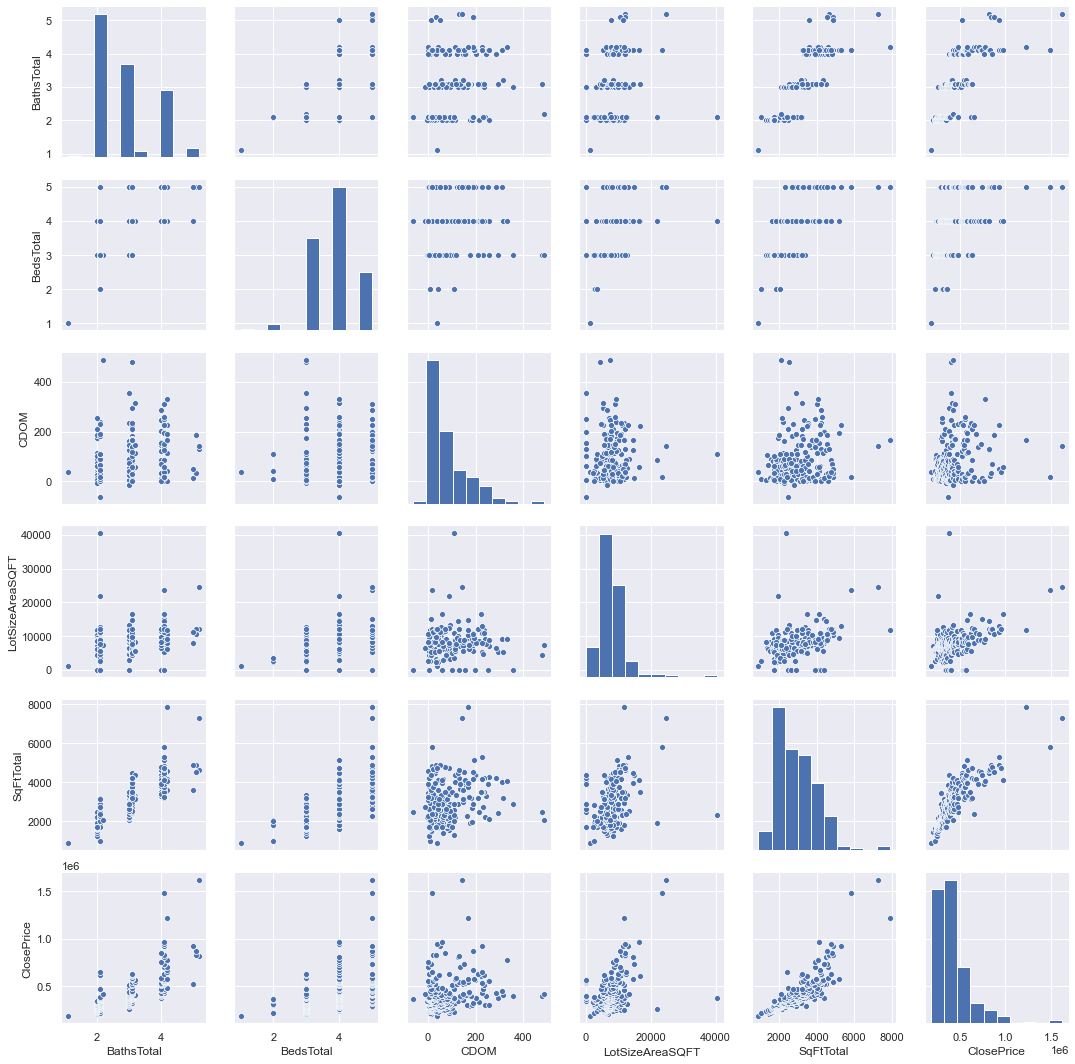

In [3]:
import seaborn as sns
corr_mat = data.corr()
sns.set()
col_names = data.columns
sns.pairplot(data[col_names], size = 2.5)
plt.show()

### Build a simple linear model
We will first build a linear regression model and then evaluate if our data indeed fits a linear model or is non-linear.

In [4]:
# Convert categorical variable into numerical value (via one-hot encoding)
home_data = data.copy()
home_data = pd.get_dummies(home_data, prefix_sep='_', drop_first=True)

In [5]:
# Model 1: Simple linear regression
X1 = home_data.drop(['ClosePrice'], axis=1)
Y1 = home_data['ClosePrice']
X_train, X_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.3, random_state=0)
line = linear_model.LinearRegression(normalize=True)
model_1 = line.fit(X_train, y_train)

print("Model score:", model_1.score(X_train, y_train))

# Predict home values on test set
ytest = np.array(y_test)
y_pred = line.predict(X_test)

# Print metrics
# print('Coefficients: \n', model_1.coef_)
print('Mean squared error: %.2f' % mean_squared_error(ytest, y_pred))
print('Coefficient of determination: %.2f' % r2_score(ytest, y_pred))

Model score: 0.873456469843831
Mean squared error: 7842352287.12
Coefficient of determination: 0.69


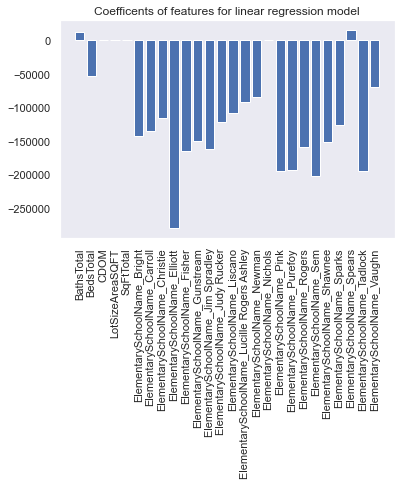

In [6]:
# Visualize coefficients for features in the simple linear model
x = np.arange(len(model_1.coef_))
labels = X1.columns
plt.bar(x, model_1.coef_)
plt.xticks(x, labels, rotation='vertical')
plt.grid()
plt.title("Coefficents of features for linear regression model")
plt.show()

### Assess linearity of the data: Plotting the residual errors vs predicted response
The R-squared values for both the training and test set shows that there is a correlation between residual error and predicted value. This indicates that the data is non-linear and therefore a simple linear regression model is not appropriate to model this data. Instead, some of the features need to be transformed.

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


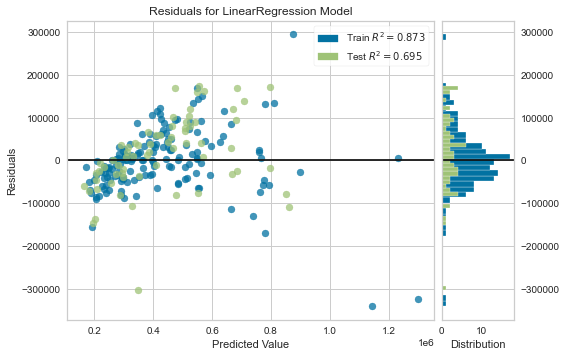

In [7]:
from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(model_1)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.show()                 

### Assess colinearity between features
According to the [docs](https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html) any feature with a VIF >5 suggests that the feature is highly collinear with other feature(s) and should be removed. In this analysis, TotalBeds, TotalBaths, LotSizeAreaSQFT, and SqFtTotal have a VIF score greater than 5. However, as mentioned above I will keep all features in the model.

In [8]:
# Calculate variance inflation factor (VIF) score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])]
vif["Feature"] = X1.columns
vif.round(2)

,VIF Factor,Feature
0,54.04,BathsTotal
1,66.82,BedsTotal
2,2.24,CDOM
3,6.40,LotSizeAreaSQFT
4,39.12,SqFtTotal
5,3.29,ElementarySchoolName_Bright
6,2.57,ElementarySchoolName_Carroll
7,2.67,ElementarySchoolName_Christie
8,1.15,ElementarySchoolName_Elliott
9,1.74,ElementarySchoolName_Fisher


### Build log-linear regression model
We see below that log transformed 'ClosePrice' has more of a normal distribution, therefore we will use log(ClosePrice) in the model. 

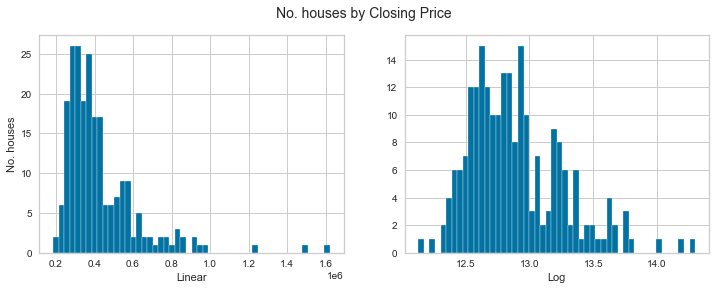

In [9]:
def subplot_histograms(data, title=""):
    '''
    Plots histograms of input data from a list of two pd.Series (linear and log tranformed data)
    '''
    f = plt.figure(figsize=(12,4))
    ax1 = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    ax1.hist(data[0], bins=50)
    ax2.hist(data[1], bins=50)
    ax1.set_ylabel('No. houses')
    ax1.set_xlabel("Linear")
    ax2.set_xlabel("Log")
    f.suptitle(title, fontsize=14)
    plt.show()
    
# Log transform data   
home_data['log_ClosePrice'] = np.log(home_data['ClosePrice'])
# home_data['log_BathsTotal'] = np.log(home_data['BathsTotal'])
# home_data['log_BedsTotal'] = np.log(home_data['BedsTotal'])
# home_data['log_CDOM'] = np.log(home_data['CDOM'])
# home_data['log_LotSizeAreaSQFT'] = np.log(home_data['LotSizeAreaSQFT'])
# home_data['log_SqFtTotal'] = np.log(home_data['SqFtTotal'])

# Replace NaN and inf values
home_data.replace([np.inf, -np.inf], np.nan, inplace=True)
home_data.replace(np.NaN, 0, inplace=True)

subplot_histograms([home_data['ClosePrice'], home_data['log_ClosePrice']], title="No. houses by Closing Price")
# subplot_histograms([home_data['SqFtTotal'], home_data['log_SqFtTotal']], title="No. houses by Total Square Feet of Home")
# subplot_histograms([home_data['LotSizeAreaSQFT'], home_data['log_LotSizeAreaSQFT']], title="No. houses by Lot Area Square Footage")
# subplot_histograms([home_data['BedsTotal'], home_data['log_BedsTotal']], title="No. houses by Total Beds")
# subplot_histograms([home_data['BathsTotal'], home_data['log_BathsTotal']], title="No. houses by Total Baths")
# subplot_histograms([home_data['CDOM'], home_data['log_CDOM']], title="No. houses by Cum. Days on Market")

In [10]:
# Log transform response
home_data = data.copy()
home_data['log_ClosePrice'] = np.log(home_data['ClosePrice'])
home_data = pd.get_dummies(home_data, prefix_sep='_', drop_first=True)

# Split data
X2 = home_data.drop(['ClosePrice', 'log_ClosePrice'], axis=1)
Y2 = home_data['log_ClosePrice']
X_train, X_test, y_train, y_test = train_test_split(X2, Y2, test_size=0.3, random_state=0)
model_2 = line.fit(X_train, y_train)

# Predict home values on test set
ytest = np.array(y_test)
y_pred = model_2.predict(X_test)

# Print metrics
# print('Coefficients: \n', model_1.coef_)
print('Intercept:', model_2.intercept_)
print('Mean squared error: %.2f' % mean_squared_error(ytest, y_pred))
print('Coefficient of determination: %.2f' % r2_score(ytest, y_pred))

Intercept: 12.46684438236764
Mean squared error: 0.02
Coefficient of determination: 0.81


In [11]:
# What is the baseline closing price of a home?
print("Min closing price: ${}".format(home_data['ClosePrice'].min()))
print("Max closing price: ${}".format(home_data['ClosePrice'].max()))
print("Average closing price: ${}".format(home_data['ClosePrice'].mean()))
print("Baseline closing price: ${}".format(math.exp(model_2.intercept_)))

Min closing price: $185000.0
Max closing price: $1622500.0
Average closing price: $427325.95067264576
Baseline closing price: $259586.27233999784


In [12]:
# How do each feature contribute to the price of a home?
percent = []
for i in model_1.coef_:
    percent.append((math.exp(i)-1)*100)

feature_name = X2.columns

print("One-unit increase in feature cause % change in closiing price:")
for i in range(len(percent)):
    print('{}: {}%'.format(feature_name[i], percent[i]))

One-unit increase in feature cause % change in closiing price:
BathsTotal: 7.286161433768412%
BedsTotal: -6.513934568930524%
CDOM: -0.004066433389093849%
LotSizeAreaSQFT: 0.0008235558978997304%
SqFtTotal: 0.025250472534810164%
ElementarySchoolName_Bright: -30.90436642811256%
ElementarySchoolName_Carroll: -29.67633172473344%
ElementarySchoolName_Christie: -27.38454772308293%
ElementarySchoolName_Elliott: -40.0118940210347%
ElementarySchoolName_Fisher: -28.465477334125744%
ElementarySchoolName_Gunstream: -31.409155182265625%
ElementarySchoolName_Jim Spradley: -26.709463822166136%
ElementarySchoolName_Judy Rucker: -23.83776050324695%
ElementarySchoolName_Liscano: -26.00436020210313%
ElementarySchoolName_Lucille Rogers Ashley: -31.17993775450324%
ElementarySchoolName_Newman: -20.822268568680137%
ElementarySchoolName_Nichols: 0.0%
ElementarySchoolName_Pink: -28.93466287971992%
ElementarySchoolName_Purefoy: -30.175845436425053%
ElementarySchoolName_Rogers: -27.505609480820237%
ElementaryScho